In [90]:
import torch 
import torch.nn as nn
import lightning as L

import xarray as xr

import matplotlib.pyplot as plt

from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

from BalticRiverPrediction.BaltNet import BaltNet
from BalticRiverPrediction.BaltNet import LightningModel
from BalticRiverPrediction.BaltNet import AtmosphereDataModule, AtmosphericDataset
from BalticRiverPrediction.sharedUtilities import read_netcdfs, preprocess

In [91]:
# Our GPU has tensor cores, hence mixed precision training is enabled
# see https://sebastianraschka.com/blog/2023/llm-mixed-precision-copy.html
# for more

torch.set_float32_matmul_precision("medium")

In [92]:
# set random seed for reproducibility
L.pytorch.seed_everything(123)

Global seed set to 123


123

Under `data/` one subdirectory stores the atmospheric data, the other the runoff data.

In [93]:
datapath="/silor/boergel/paper/runoff_prediction/data"

data = read_netcdfs(
    files=f"{datapath}/atmosphericForcing/????/rain.mom.dta.nc",
    dim="time",
    transform_func=lambda ds:preprocess(ds)
    )       

runoff = read_netcdfs(
    f"{datapath}/runoffData/combined_fastriver_*.nc",
    dim="river",
    transform_func= lambda ds:ds.sel(time=slice(str(1979), str(2011))).roflux.resample(time="1D").mean(),
    cftime=False
    )  

100%|██████████| 97/97 [04:23<00:00,  2.72s/it]


In [94]:
config = {
"input_dim":30, # timesteps
"hidden_dim":1, # Channels -> right now only precipitation
"kernel_size":(3,3), # applied for spatial convolutions
"num_layers":2, # number of convLSTM layers
"batch_first":True, # first index is batch
"bias":True, 
"return_all_layers": False, 
"dimensions": (191, 206) # dimensions of atmospheric forcing
}

num_epochs = 50

In [95]:
dataLoader = AtmosphereDataModule(
data=data,
runoff=runoff,
batch_size=64,
input_size=config["input_dim"]
)

num_epochs = 50


TypeError: AtmosphereDataModule.__init__() got an unexpected keyword argument 'data'

In [ ]:
# initalize model
pyTorchBaltNet = BaltNet(modelPar=config)

# Lightning model wrapper
LighningBaltNet = LightningModel(
    pyTorchBaltNet,
    learning_rate=1e-3,
    cosine_t_max=num_epochs
)

In [ ]:
LighningBaltNet = LightningModel.load_from_checkpoint(
    checkpoint_path="/silor/boergel/paper/runoff_prediction/data/modelWeights/BaltNetTopOne.ckpt",
    learning_rate=1e-3,
    model=pyTorchBaltNet
)

In [ ]:
data = AtmosphericDataset(
    datapath="/silor/boergel/paper/runoff_prediction/data"
    )

  0%|          | 0/54 [00:00<?, ?it/s]

100%|██████████| 97/97 [03:45<00:00,  2.32s/it]


In [ ]:
predict_dataloader = DataLoader(
    data,
    batch_size=32,
    shuffle=False
    )

In [ ]:
trainer = L.Trainer(
    inference_mode=True,
    accelerator="cuda",
    devices=1,
    deterministic=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
predictions = trainer.predict(LighningBaltNet, dataloaders=predict_dataloader)
concatenated_predictions = torch.cat(predictions, dim=0)
rescaledRunoffData = concatenated_predictions*data.runoffData[1].data+data.runoffData[0].data


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/silos/conda_packages/boergel/miniconda3_4.12.0/OS_15.4/conda_env/BaltNet/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 376/376 [00:18<00:00, 20.54it/s]


In [ ]:
datapath = "/silor/boergel/paper/runoff_prediction/data"

origianlRunoff = read_netcdfs(
    f"{datapath}/runoffData/combined_fastriver_*.nc",
    dim="river",
    transform_func= lambda ds:ds.sel(time=slice(str(1979), str(2011))).roflux.resample(time="1D").mean(),
    cftime=False
    )

origianlRunoffData = origianlRunoff.transpose("time", "river")
origianlRunoffData = origianlRunoffData.resample(time="1D").mean()

100%|██████████| 97/97 [03:48<00:00,  2.35s/it]


In [ ]:
rescaledRunoffDataDataset = xr.DataArray(
    data = rescaledRunoffData.data,
    coords={
        "time": origianlRunoffData.time[30:],
        "river": origianlRunoffData.river
    }
)


In [ ]:
origianlRunoffData

<xarray.DataArray 'roflux' (time: 12053, river: 97)>
array([[ 19.89773683,  28.18225956, 565.54025269, ..., 284.90733337,
        358.94662476,   6.25746036],
       [ 19.77334802,  27.97537924, 561.38873389, ..., 283.07602962,
        356.63941906,   6.21723919],
       [ 19.64895922,  27.76849891, 557.2372151 , ..., 281.24472587,
        354.33221337,   6.17701802],
       ...,
       [ 26.67110062,  16.71035957, 187.04728699, ..., 428.19915771,
        519.69726562,  17.8742218 ],
       [ 28.06932068,  16.61111832, 187.64691162, ..., 418.31317139,
        508.81030273,  17.27508926],
       [ 36.25814438,  18.89372635, 188.54785156, ..., 409.12901306,
        498.52636719,  16.47635651]])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2011-12-31
Dimensions without coordinates: river
Attributes:
    units:    m**3/s
    basin:    Kattegat
    lon:      11.097068
    lat:      53.974945

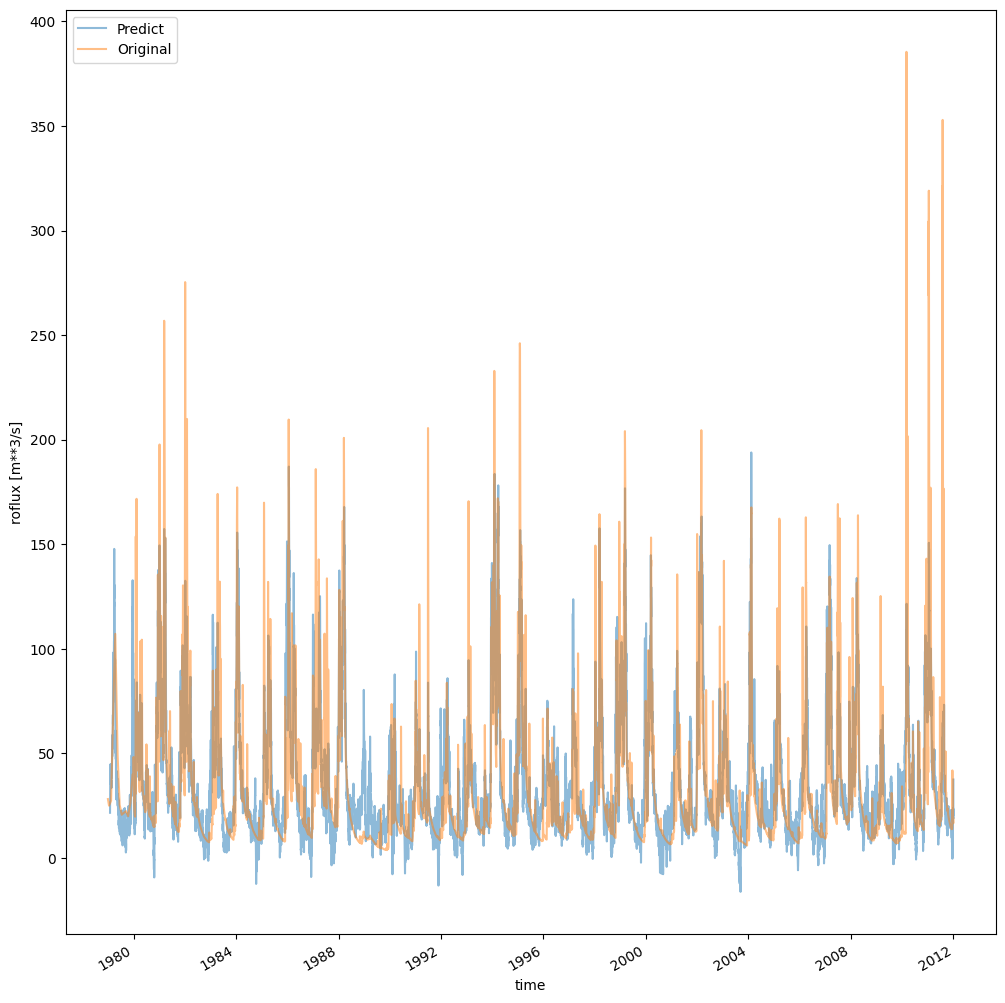

In [ ]:
f, ax = plt.subplots(1, figsize=(12,12))
rescaledRunoffDataDataset.isel(river=1).plot(ax=ax, label = "Predict", alpha=.5)
origianlRunoff.isel(river=1).plot(ax=ax, label="Original", alpha=0.5)
plt.legend()

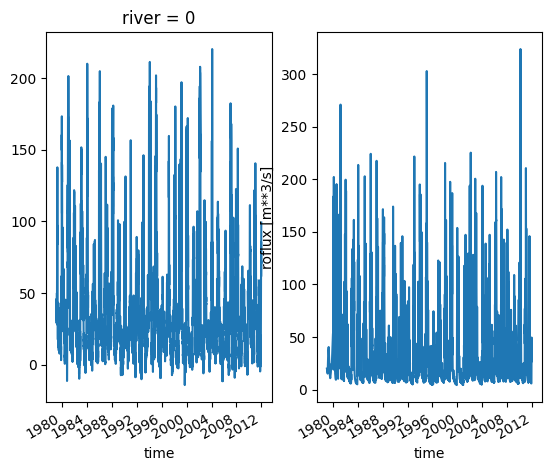

In [ ]:
f, ax = plt.subplots(1, 2)

rescaledRunoffDataDataset.isel(river=0).plot(ax=ax[0])
origianlRunoff.isel(river=0).plot(ax=ax[1])

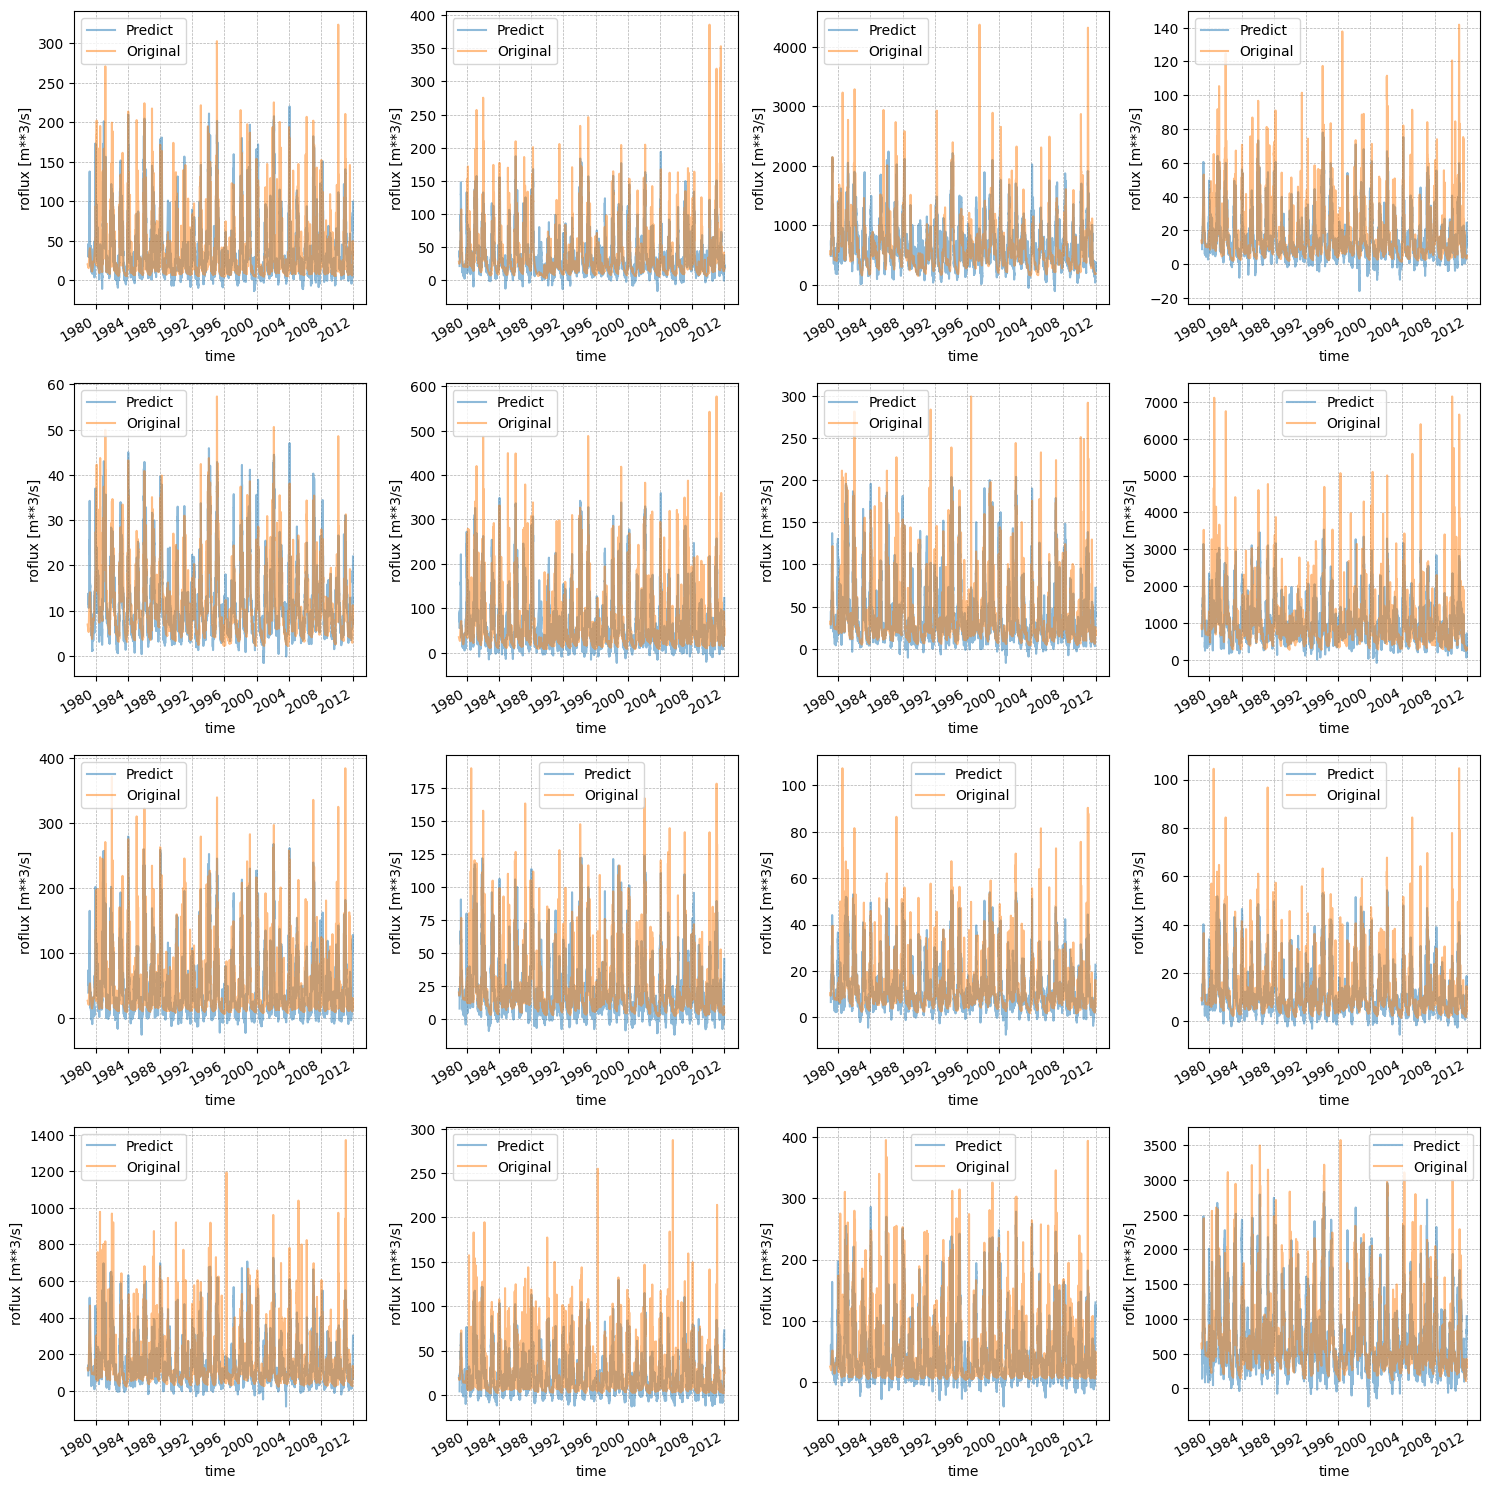

In [ ]:
f, axs = plt.subplots(4, 4, figsize=(15, 15))

for i, ax in enumerate(axs.ravel()):
    ax.set_title(f"River {i+1}")
    rescaledRunoffDataDataset.isel(river=i).plot(ax=ax, label = "Predict", alpha=.5)
    origianlRunoff.isel(river=i).plot(ax=ax, label="Original", alpha=0.5)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
plt.tight_layout()


In [ ]:
class TaylorDiagram(object):
    """
    Taylor diagram.
    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """
    def __init__(self, refdata, ax,  *args, **kwargs):
        # memorize reference data
        self.refdata = refdata
        self.ax = ax
        refstd = refdata.std(ddof=1) 
        rlim = [0.0, 1.2*refstd]
        thetalim = [0.0, 0.5*np.pi]
        if ax != None:
            # Add reference point and stddev contour
            try:
                kwargs["marker"]
            except:
                kwargs["marker"] = 'o'
            try:
                kwargs["color"]
            except:
                kwargs["color"] = "black"
            try:
                kwargs["ms"]
            except:
                kwargs["ms"] = 10     
            try:
                kwargs["label"]
            except:
                kwargs["label"] = "reference"                     
            ax.plot([0], refstd, *args, ls='', zorder=0, **kwargs)
            ax.grid(True, linestyle="--")
            
            ax.set_xlabel("St. dev.")
            ax.xaxis.set_label_coords(0.5, -0.1)
            ax.set_xlim(thetalim)
            ax.set_ylim(rlim)
            self.rlim = rlim
            self.thetalim = thetalim
        self.model_std = {"reference" : refstd}
        self.corrcoef = {"reference" : 1.0}
        self.rms = {"reference" : 0.0}
    def add_sample(self, model_data, *args, **kwargs):
        """
        Add sample to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """
        model_std = model_data.std(ddof=1)
        corrcoef = np.corrcoef(model_data, self.refdata)[0, 1]
        rms = np.sqrt(self.model_std["reference"]**2 + model_std**2 - 2.0*self.model_std["reference"]*model_std*np.cos(np.arccos(corrcoef)))
        try:
            label = kwargs["label"]
        except:
            label = "model"+str(len(self.model_std.keys())) 
        if self.ax != None:
            self.ax.plot(np.arccos(corrcoef), model_std,
                            *args, **kwargs)  # (theta, radius)
            if model_std > self.rlim[1]:
                self.rlim = [0, 1.2 * model_std]
                self.ax.set_ylim(*self.rlim)
            if np.arccos(corrcoef) > self.thetalim[1]:
                self.thetalim[1] = 1.2 * np.arccos(corrcoef)
                self.ax.set_xlim(*self.thetalim)                       
        self.model_std[label] = model_std
        self.corrcoef[label] = corrcoef
        self.rms[label] = rms
        #self.ax.set_ylim(rlim) 
    def get_samples(self):
        return self.model_std, self.corrcoef, self.rms
    def finalize(self):
        
        if self.ax is None:
            return 
        self.ax.text(0.5*(self.thetalim[1]-self.thetalim[0]), (1.0+0.03*(self.thetalim[1]-self.thetalim[0])**2)*self.rlim[1],"Correlation", rotation=0.5*(self.thetalim[1]-self.thetalim[0])*180.0/np.pi-90.0)
        rs, ts = np.meshgrid(np.linspace(*self.rlim), np.linspace(*self.thetalim))
        rms = np.sqrt(self.model_std["reference"]**2 + rs**2 - 2.0*self.model_std["reference"]*rs*np.cos(ts))
        self.ax.contourf(ts, rs, rms, 9, alpha=0.3, cmap="RdYlGn_r")
        contours = self.ax.contour(ts, rs, rms, 9, linestyles="--", linewidths=1, alpha=0.5, colors="grey")
        if self.model_std["reference"] > 100.0 or self.model_std["reference"] < 0.1:
            fmt = '%3.2e'
        else:
            fmt = '%3.2f'
        self.ax.clabel(contours, inline=False, fmt=fmt, colors="black")
        t = np.linspace(*self.thetalim)
        r = np.zeros_like(t) + self.model_std["reference"]
        self.ax.plot(t, r, 'k--', label='_')
        xticks = [1.0, 0.99, 0.95, 0.9, 0.8, 0.7, 0.6, 0.4, 0.2, 0.0]
        if self.thetalim[1] > 0.5*np.pi:
            for x in [-0.2, -0.4, -0.6, -0.8, -0.9, -0.95, -0.99 -1.0]:
                if np.arccos(x) > self.thetalim[1]:
                    break
                xticks += [x]
        self.ax.set_xticks(np.arccos(xticks))
        self.ax.set_xticklabels(xticks)

In [ ]:
diagram = TaylorDiagram(d, axs[i,j])
diagram.add_sample(dm, marker='*', ms=10, ls='', color=RGB_tuples[k], label=model)
diagram.finalize()

# d - referenz daten
# dm - data model